안녕하세요, 퀀트대디입니다.

이번 시간에는 투자의 위험, 즉 리스크를 측정하는 여러 가지 위험지표들에 대해서 배워보고 또 이를 구현해보도록 하겠습니다.

# 0. 초기 셋업

`yfinance` 패키지를 다음과 같이 설치해줍니다.

`yfinance` 패키지가 설치되었으니 이제 필요한 라이브러리들을 임포트해줍니다. 파이썬을 자주 사용하는 사람들에게 `numpy`, `pandas`, `matplotlib` 삼형제는 항상 필수적인 라이브러리입니다. 여기서는 총 네 개의 라이브러리를 임포트해줍니다.

In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

필요한 라이브러리들이 성공적으로 임포트되었으니 이제는 이번 시간에 필요한 가격 데이터를 다운받아 보겠습니다. 여기서는 SPY와 TLT, 두 개의 ETF 과거 데이터를 불러와보겠습니다. 시작일은 2002년 7월 30일이고, 종료일은 현재입니다. 수정종가만은 남겨놓고 전부 지워준 뒤 주간 가격 데이터로 변환합니다.

In [2]:
# 데이터 다운로드
data = yf.download('SPY TLT', start='2002-07-30')

# 수정종가를 제외한 나머지 컬럼 삭제
data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

# 첫 번째 컬럼 레벨을 삭제
data = data.droplevel(0, axis=1)

# 가격 데이터를 주간 단위로 재설정
data = data.resample('W').last()

[*********************100%***********************]  2 of 2 completed


In [3]:
data

,SPY,TLT
Date,,
2002-08-04,58.141174,41.878189
2002-08-11,61.155750,42.392586
2002-08-18,62.448677,42.482552
2002-08-25,63.373135,42.902012
2002-09-01,61.484032,43.491417
...,...,...
2023-05-28,418.465546,100.822037
2023-06-04,426.336334,101.989998
2023-06-11,428.308990,101.919998


# 1. 하방표준편차 (Semi-Deviation)

첫 번째 위험지표는 바로 하방표준편차입니다. 하방표준편차는 이전에 다루었던 표준편차와 거의 비슷한 개념입니다. 단지 차이점이 있다면, 하방표준편차는 수익률이 플러스인 경우를 전부 0으로 처리하고 표준편차를 계산한다는 것입니다. 이는 다시 말해, 수익률이 마이너스인 경우의 표준편차를 리스크의 지표로 사용하겠다는 의미입니다. 하방표준편차는 다음과 같은 공식을 사용해 계산할 수 있습니다.

하방표준편차

$$ Dσ = \sqrt{\frac{1}{N-1}Σ_{i=1}^{N}[min(r_{i}, 0)]^{2}} $$

하방표준편차는 성과지표 중 하나인 소르티노비율을 계산하기 위해 필요한 값입니다. 파이썬을 활용해 하방표준편차를 계산하고 또 이를 시각화해보겠습니다.

Text(0, 0.5, 'Down Deviation')

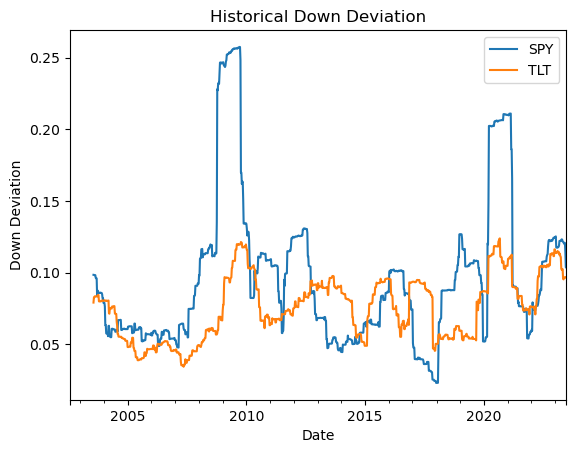

In [4]:
# 각 ETF 가격 데이터 추출
spy_price = data['SPY']
tlt_price = data['TLT']

# 수익률 계산
spy_ret = spy_price.pct_change().fillna(0)
tlt_ret = tlt_price.pct_change().fillna(0)

# 수익률이 플러스인 경우 값을 0으로 변환
spy_ret.loc[spy_ret >= 0] = 0
tlt_ret.loc[tlt_ret >= 0] = 0

# 하방표준편차 계산
spy_down_dev = spy_ret.rolling(52).std() * np.sqrt(52)
tlt_down_dev = tlt_ret.rolling(52).std() * np.sqrt(52)

# 하방표준편차 시각화
spy_down_dev.plot(label='SPY', legend=True)
tlt_down_dev.plot(label='TLT', legend=True)
plt.title('Historical Down Deviation')
plt.xlabel('Date')
plt.ylabel('Down Deviation')


# 2. 낙폭(Drawdown)과 최대낙폭(MDD; Maximum Drawdown)

두 번째 위험지표는 낙폭과 그것의 최대치인 최대낙폭입니다. 퀀트 투자에서 가장 많이 다뤄지는 위험지표인데요. 퀀트 투자의 장점은 과거에 어떤 전략을 사용했다면 어느 정도의 수익과 손실이 났었는지를 검증해볼 수 있다는 것입니다. 우리는 특히 손실에 민감하기 때문에 역사적으로 어느 정도의 손실이 났었는지를 확인해본다면 해당 전략에 얼마만큼을 투자하는 것이 적정한지 생각해볼 수도 있겠죠. 그런 의미에서 낙폭과 최대낙폭을 계산해보는 것은 퀀트 투자를 함에 있어서 필수적인 작업입니다.

낙폭이라는 개념은 단어 의미 그대로 떨어진 정도를 의미합니다. 다만 여기서 낙폭의 정의는 과거 전고점 대비 얼마나 하락했는지를 의미합니다. 전고점 대비 현재 가격을 비교하여 낙폭, 즉 손실율을 계산합니다. 낙폭을 계산하기 위한 공식은 다음과 같습니다.

낙폭
$$ DD_{t} = \frac{P_{t}}{HWM_{t}} - 1 $$

여기서 $P_{t}$는 현재 가격을 의미하여, $HWM{t}$는 전고점, 즉 과거부터 지금까지 가격 중 최고가를 의미합니다. 가격을 전고점으로 나눈 후에 1을 빼주면 역사적인 낙폭 수준이 퍼센티지 수익률 기준으로 계산됩니다. 최대낙폭은 당연히 지금까지의 낙폭 중 최대로 많이 손실을 본 낙폭을 의미하겠죠. 따라서 최대낙폭의 공식은 심플하게 다음과 같습니다.

최대낙폭
$$ MDD_{t} = min(DD_{t}) $$

전고점 데이터가 필요한 낙폭 계산의 특성상 그렇다면 낙폭 계산의 관건은 바로 가격 데이터를 사용해서 지속적으로 역사적인 고점을 기록해나가야 하는 것이라고 할 수 있습니다. 언뜻 생각해보면 어떻게 할지 감이 안오지만 파이썬은 이마저도 굉장히 쉽게 구현을 해줍니다. `pandas`의 `cummax()` 메서드를 사용하면 데이터프레임을 하나하나 거치면서 역사적 최고점을 데이터가 들어있는 데이터프레임을 얻을 수 있습니다. 이후 가격을 다시 이것으로 나누어준 뒤 1을 빼주면 낙폭 데이터프레임을 생성할 수 있습니다. 아래의 코드는 SPY ETF의 낙폭을 계산하기 위한 파이썬 코드입니다.

In [5]:
# SPY 역사적 전고점 계산
spy_hwm = spy_price.cummax()

# SPY 낙폭 계산
spy_dd = (spy_price / spy_hwm) - 1

낙폭이 제대로 계산되었는지 이를 그래프로 그려보겠습니다. 여기서는 `matplotlib`의 `add_subplot()` 메서드를 사용해 한 화면에 두 개의 그래프를 그려보도록 하겠습니다. 위쪽 그래프는 SPY 가격과 전고점이 표시된 그래프이고, 아래쪽 그래프는 낙폭이 기록되어 있는 그래프입니다. 한눈에 봐도 언제 제일 큰 손실을 보았는지 직관적으로 알 수 있습니다.

Text(0, 0.5, 'Return')

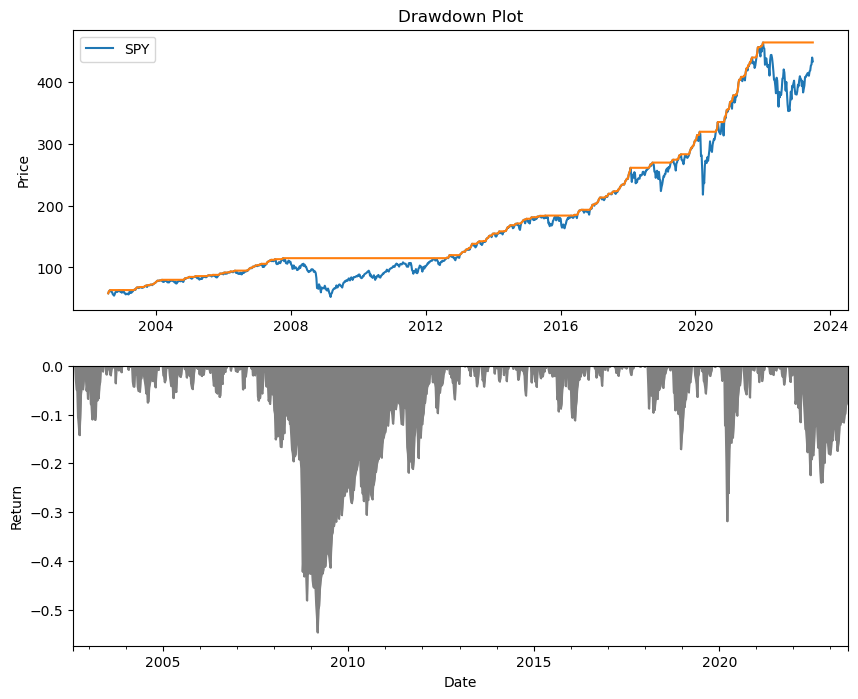

In [6]:
# SPY 낙폭 시각화
fig = plt.figure(figsize=(10, 8))

# 위쪽 그래프 시각화
ax1 = fig.add_subplot(2, 1, 1)
plt.title('Drawdown Plot')
plt.plot(spy_price, label='SPY')
plt.plot(spy_hwm)
plt.legend()
plt.ylabel('Price')

# 아래쪽 그래프 시각화
ax2 = fig.add_subplot(2, 1, 2)
spy_dd.plot.area(color='grey')
plt.xlabel('Date')
plt.ylabel('Return')

In [7]:
spy_dd.min()

-0.5461304098485652

# 3. 최대예상손실액 VaR (Value-at-Risk)

세 번째 위험지표는 바로 최대예상손실액, 영어로 바(VaR)라고 불리는 녀석입니다. 리스크 부서에서 항상 취급하는 위험지표 중 하나인 이 바는 시장에서 최악의 이벤트가 발생한다면 특정 확률상 얼마만큼의 손실을 볼 수 있을가를 측정하는 지표입니다. 예를 들어, 99% VaR라고 한다면 전체 수익률 분포 중 위로부터 99분위, 즉 하위 1%에 해당하는 수익률 값을 의미합니다. 이를 해석하자면 정상적인 시장 상황에서 99% VaR보다 더 큰 손실이 올 확률은 1%라고 보는 것입니다. 그만큼 아주 최악의 경우를 가정했을 때 예상할 수 있는 수익률이라고 볼 수 있습니다. 물론 VaR이 수익률의 정규분포라는 다소 무리한 가정을 하고 있다는 점은 이 위험지표의 한계이지만, 실무적으로는 자주 스트레스 테스트를 수행하는 데 있어 통상적으로 사용되고 있는 지표입니다. 

VaR을 계산하는 방법에는 크게 1) 모수적 방법(델타 노말), 2) 비모수적 방법(역사적 VaR), 3) 몬테카를로 방법(몬테카를로 VaR), 4) 수정 VaR(Cornish-Fisher VaR)로 나뉘지만, 여기서는 과거 수익률 데이터에 기반한 역사적 VaR만을 다루겠습니다. 역사적 VaR를 계산하는 공식은 다음과 같습니다. 단순히 과거 수익률 데이터를 작은 녀석부터 순서대로 줄세운 다음에 하위 1%에 위치한 값을 선택하면 됩니다.

Value-at-Risk
$$ VaR_{δ} = Quantile(R, δ) $$

여기서 $R$은 수익률 데이터를 의미하며, $Quantile()$은 차례대로 줄을 세운 뒤 하위 $δ\%$의 값을 추출하는 함수입니다. `pandas`의 `quantile()` 메서드를 활용하면 이 또한 쉽게 구현이 가능합니다.

In [8]:
# SPY 수익률 계산
spy_ret = spy_price.pct_change().fillna(0)

# SPY 99% VaR 계산
spy_VaR = spy_ret.quantile(0.01)
print('VaR = {}'.format(spy_VaR))

VaR = -0.06572073975638912


VaR가 계산되었으니 이를 히스토그램으로 시각화해보겠습니다. `matplotlib`의 `hist()` 메서드를 사용해 SPY 수익률 데이터에 대한 히스토그램을 그립니다. 그 다음에 `axvline()` 메서드를 사용해 그래프에다가 빨간색 점선으로 VaR 지점을 표시해보도록 하겠습니다.

Text(0, 0.5, 'Frequency')

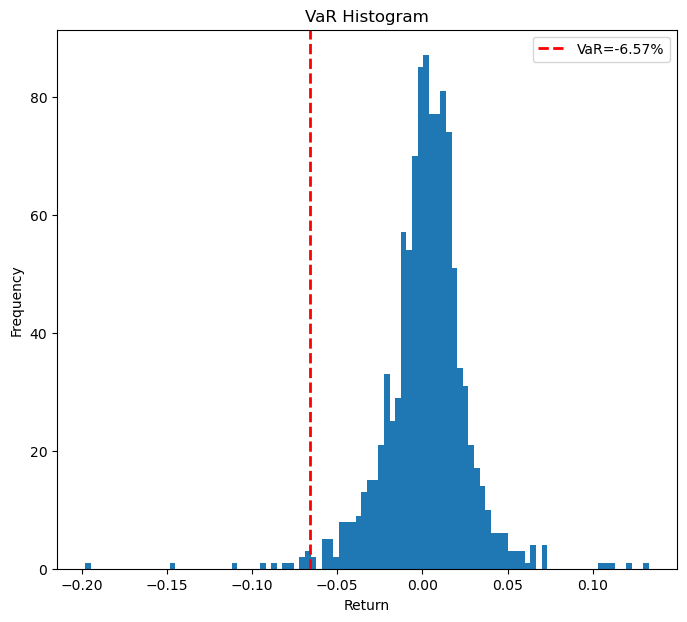

In [9]:
# VaR 히스토그램 시각화
plt.figure(figsize=(8, 7))

# SPY 수익률 히스토그램
plt.hist(spy_ret, bins=100)

# VaR 지점 수직선 표시
plt.axvline(spy_VaR, color='r', linestyle='dashed', linewidth=2, label='VaR={}%'.format(np.round(spy_VaR* 100, 2)))

plt.title('VaR Histogram')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Frequency')


# 4. 조건부 최대예상손실액 CVaR (Conditional Value-at-Risk)

마지막 위험지표는 VaR에서 한 단계 발전한 위험지표인 조건부 최대예상손실액입니다. 영어로는 씨바(CVaR)라고 읽습니다. (발음에 주의하시길 바랍니다!) CVaR는 VaR보다 좀 더 보수적인 위험지표입니다. CVaR는 VaR 값 이하인 수익률들의 평균값을 의미합니다. 최악의 상황들을 모아놓은 경우의 수익률이라고 할 수 있습니다. CVaR을 계산하는 공식은 다음과 같습니다.


Conditional Value-at-Risk
$$ CVaR_{δ} = E(R|R \leq VaR_{δ}) $$


CVaR의 경우는 이후 성과지표를 계산하는 사용될 뿐만 아니라 포트폴리오의 베팅 사이즈를 결정하는 알고리즘 중 하나인 CVaR 타겟팅 모델에서도 다시 만나게 됩니다.

아래는 CVaR를 계산하기 위한 코드입니다. CVaR를 계산하기 위해서는 당연히 VaR 값을 미리 계산해놓아야 합니다.

In [10]:
# CVaR 계산
spy_CVaR = spy_ret[spy_ret <= spy_VaR].mean()
print('SPY CVaR = {}'.format(spy_CVaR))

SPY CVaR = -0.09742386600954092


CVaR가 계산되었으니 이를 또 시각화해보겠습니다. 여기서는 히스토그램을 사용하되 VaR 값보다 낮은 수익률 데이터만을 가지고 그려보겠습니다. 또한 VaR 값은 초록색 수직점선으로, CVaR 값은 빨간색 수직점선으로 표시해보겠습니다.

Text(0, 0.5, 'Frequency')

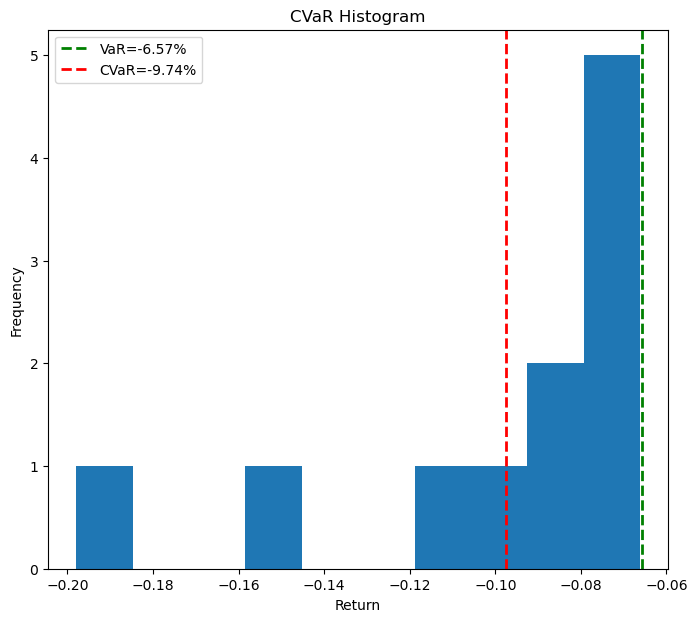

In [11]:
# CVaR 히스토그램 시각화
plt.figure(figsize=(8, 7))

# VaR 값보다 작은 수익률 데이터들의 히스토그램
plt.hist(spy_ret[spy_ret <= spy_VaR])

# VaR 수직선 표시
plt.axvline(spy_VaR, color='g', linestyle='dashed', linewidth=2, label='VaR={}%'.format(np.round(spy_VaR * 100, 2)))

# CVaR 수직선 표시
plt.axvline(spy_CVaR, color='r', linestyle='dashed', linewidth=2, label='CVaR={}%'.format(np.round(spy_CVaR * 100, 2)))

plt.title('CVaR Histogram')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Frequency')